In [1]:
import math
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import time
import requests # <-- ADD THIS IMPORT
from numpy.random import uniform
import pandas_datareader.data as web
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# --- Tickers from the successful previous run ---
final_ticker_list = ["GOOGL", "AMZN", "WMT", "XOM", "JPM", "UNH", "AAPL", "NEE"]
# Define the date range (pandas_datareader expects datetime objects)
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2025, 11, 21)
# -----------------------------------------------

# Define the data source
DATA_SOURCE = 'stooq' 

print(f"\n--- Attempting download using {DATA_SOURCE.upper()} ---")

try:
    # web.DataReader fetches data for multiple symbols at once from Stooq
    # Stooq returns Daily data, so we'll fetch daily and then resample to weekly.
    all_stock_data_stooq = web.DataReader(
        final_ticker_list, 
        data_source=DATA_SOURCE, 
        start=start_date, 
        end=end_date
    )

    print(f"Stooq download successful! Fetched {len(all_stock_data_stooq)} daily records.")
    
    # 3. Process and Resample Data to Weekly Interval (to match your original goal)
    
    # Stooq returns a MultiIndex DataFrame where the date is the index, and the first
    # column level is the price type (Open, High, Low, Close, Volume) and the second is the Ticker.
    
    # Swap the levels to get Ticker on top, then Date, then resample.
    # We use 'W' (Weekly) to match your original request interval="1wk"
    all_stock_data_weekly = (
        all_stock_data_stooq
        .swaplevel(axis=1) # Swap Ticker and Price Type levels
        .sort_index(axis=1, level=0) # Sort by Ticker
        .resample('W') # Resample to weekly data
        .last() # Use the last price of the week for the close
    )
    
    # Get the Adjusted Close Prices for all stocks (Stooq uses 'Close' for adjusted prices)
    close_prices_stooq = all_stock_data_weekly.xs('Close', axis=1, level=1)
    
    print("\n✅ Data is ready for analysis!")
    
    print("\nAdjusted Close Prices (Weekly Tidy Format from Stooq):")
    print(close_prices_stooq.head())
    
    print("\nData is now in a clean DataFrame. You can proceed with your algorithms.")

except Exception as e:
    print(f"\n❌ Stooq download failed: {e}. If the issue persists, your network or firewall might be blocking the connection.")
    # If this fails, the issue is likely not rate-limiting but a general network connection issue.


--- Attempting download using STOOQ ---
Stooq download successful! Fetched 1482 daily records.

✅ Data is ready for analysis!

Adjusted Close Prices (Weekly Tidy Format from Stooq):
Symbols        AAPL      AMZN    GOOGL      JPM      NEE      UNH      WMT  \
Date                                                                         
2020-01-05  72.0115   93.7485  67.8302  127.049  56.5242  265.978  36.8987   
2020-01-12  75.1306   94.1580  71.1899  124.957  57.2824  271.136  36.4200   
2020-01-19  77.1667   93.2360  73.7088  126.912  59.5990  274.203  35.9773   
2020-01-26  77.0633   93.0820  73.0438  122.295  62.0269  268.989  35.7913   
2020-02-02  74.9374  100.4360  71.3803  121.548  63.0832  250.299  35.8310   

Symbols         XOM  
Date                 
2020-01-05  59.0136  
2020-01-12  58.0159  
2020-01-19  57.5296  
2020-01-26  55.6488  
2020-02-02  52.1264  

Data is now in a clean DataFrame. You can proceed with your algorithms.


In [3]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [13]:
# Assuming 'close_prices_stooq' is the DataFrame from the previous step,
# where the index is the date/week and columns are the tickers.
# This DataFrame should contain the adjusted closing prices.

# 1. Calculate the periodic return (e.g., weekly return)
# The pct_change() method calculates (P_t - P_{t-1}) / P_{t-1} for all columns.
ret = close_prices_stooq.pct_change()

# 2. Drop the first row, which will contain NaNs (Not a Number) 
# because there is no prior price to calculate the first return.
ret = ret.dropna(how='all')

print("\n✅ Returns DataFrame Created (Fractional Returns):")
print(ret)
print(f"\nShape of the Returns DataFrame: {ret.shape}")


✅ Returns DataFrame Created (Fractional Returns):
Symbols         AAPL      AMZN     GOOGL       JPM       NEE       UNH  \
Date                                                                     
2020-01-12  0.043314  0.004368  0.049531 -0.016466  0.013414  0.019393   
2020-01-19  0.027101 -0.009792  0.035383  0.015645  0.040442  0.011312   
2020-01-26 -0.001340 -0.001652 -0.009022 -0.036380  0.040737 -0.019015   
2020-02-02 -0.027586  0.079006 -0.022774 -0.006108  0.017030 -0.069482   
2020-02-09  0.036404  0.035127  0.032334  0.036537  0.004932  0.061502   
...              ...       ...       ...       ...       ...       ...   
2025-10-26  0.041738  0.052431  0.026135  0.009679 -0.001420  0.016545   
2025-11-02  0.028727  0.089247  0.081833  0.035548 -0.035659 -0.057766   
2025-11-09 -0.007027  0.000778 -0.008393  0.009932  0.031081 -0.050796   
2025-11-16  0.014676 -0.039769 -0.008679 -0.033735 -0.000596 -0.007248   
2025-11-23 -0.003341 -0.059866  0.084440 -0.018412 -0.004769 

In [4]:
def drawdown_durations(series):
    """
    Calculate durations of drawdown periods in a price or cumulative return series.
    
    Parameters:
    - series: pd.Series of cumulative returns or prices
    
    Returns:
    - durations: list of drawdown durations (in number of periods)
    - max_duration: longest drawdown duration
    """
    running_max = series.cummax()
    in_drawdown = series < running_max

    durations = []
    current_duration = 0

    for drawdown in in_drawdown:
        if drawdown:
            current_duration += 1
        elif current_duration > 0:
            durations.append(current_duration)
            current_duration = 0

    # Catch trailing drawdown
    if current_duration > 0:
        durations.append(current_duration)

    return durations, max(durations) if durations else 0

In [5]:
def max_drawdown(x):
    """
    Compute max drawdown for a Series or each column in a DataFrame.
    
    Parameters:
    - x: pd.Series or pd.DataFrame of cumulative returns or prices
    
    Returns:
    - float (for Series) or pd.Series (for DataFrame)
    """
    def compute_dd(series):
        running_max = series.cummax()
        drawdown = series - running_max
        return drawdown.min()
    
    if isinstance(x, pd.Series):
        return compute_dd(x)
    elif isinstance(x, pd.DataFrame):
        return x.apply(compute_dd)
    else:
        raise TypeError("Input must be a pandas Series or DataFrame")


In [6]:
def percent_time_in_drawdown(series):
    """
    Calculate the percentage of time the series is in drawdown.
    
    Parameters:
    - series: pd.Series of cumulative returns or prices
    
    Returns:
    - float: percentage of time in drawdown
    """
    running_max = series.cummax()
    in_drawdown = series < running_max
    percent = in_drawdown.sum() / len(series) * 100
    return percent

In [7]:
def calculate_sortino_ratio(returns, annual_periods):
    """Calculates the Annualized Sortino Ratio (MAR=0)."""
    # Downside deviation (only penalize negative returns)
    downside_returns = returns.loc[returns < 0]
    downside_deviation = downside_returns.std()
    
    # Sortino Ratio = (Annualized Mean Return) / (Annualized Downside Deviation)
    annualized_mean = returns.mean() * annual_periods
    annualized_downside_deviation = downside_deviation * np.sqrt(annual_periods)
    
    if annualized_downside_deviation == 0:
        return np.nan
    return annualized_mean / annualized_downside_deviation

def calculate_cagr(returns, annual_periods):
    """Calculates the Compound Annual Growth Rate (CAGR)."""
    total_periods = len(returns)
    if total_periods == 0:
        return 0
    # Annualized factor: (annual_periods / total_periods)
    cagr = (1 + returns).prod()**(annual_periods / total_periods) - 1
    return cagr

def calculate_calmar_ratio(cagr, max_drawdown):
    """Calculates the Calmar Ratio."""
    # max_drawdown is negative, so we use -max_drawdown
    if max_drawdown == 0:
        return np.nan
    return cagr / abs(max_drawdown)

In [8]:
def calculate_ic(signal, next_returns):
    """
    Calculates the Information Coefficient (IC) - the cross-sectional 
    rank correlation between the signal and the next period's returns.
    """
    # Ensure signal and returns are aligned by time index
    aligned_df = pd.concat([signal, next_returns], axis=1).dropna()
    
    # Calculate the rank correlation (Spearman's correlation) across all assets for each time period
    # Axis=1 (across columns/assets) gives a time series of ICs
    ic_series = aligned_df.iloc[:, 0].corr(aligned_df.iloc[:, 1], method='spearman')
    
    # Return the mean of the IC time series (the overall average predictive power)
    return ic_series.mean() if not ic_series.empty else np.nan

In [9]:
def calculate_win_loss_ratio(returns):
    """Calculates the ratio of winning periods to losing periods."""
    if returns.empty:
        return np.nan
    winning_periods = (returns > 0).sum()
    losing_periods = (returns < 0).sum()
    if losing_periods == 0:
        return np.inf  # Avoid division by zero, indicates perfect record
    return winning_periods / losing_periods

In [11]:
from binance.client import Client as bnb_client
import math
from datetime import datetime
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
#client = bnb_client()
###  if you're in the US, use: 
client = bnb_client(tld='US')#" here instead

def get_binance_px(symbol,freq,start_ts = '2022-3-9',end_ts='2025-11-22'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

univ = ['BTCUSDT','NEARUSDT','ATOMUSDT','HBARUSDT','ETHUSDT','ADAUSDT','LINKUSDT','SUIUSDT','XLMUSDT','BNBUSDT','ICPUSDT','UNIUSDT','LTCUSDT','AAVEUSDT','XRPUSDT','AVAXUSDT','ETCUSDT','DOTUSDT']
freq = '4h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
returns_crypto = px.pct_change()

C:\Users\ephet\AppData\Local\Temp\ipykernel_2208\3899473038.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
C:\Users\ephet\AppData\Local\Temp\ipykernel_2208\3899473038.py:20: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
C:\Users\ephet\AppData\Local\Temp\ipykernel_2208\3899473038.py:32: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-lead


--- Strategy 1 (Crypto) Calculated. ---
Starting Stock Reversal Strategy (H=26, N=5)...
--- Strategy 2 (Stock) Calculated. ---

### Starting Final Portfolio Combination (Static Inverse Volatility) ###

--- Final Static Inverse Volatility Weights ---
Volatility Strategy A (Stock): 0.03134
Volatility Strategy B (Crypto): 0.09260
Weight Strategy A (W_A): 0.747
Weight Strategy B (W_B): 0.253

--- Final Combined Portfolio Performance ---
Final Annualized Sharpe Ratio: 1.276
Final Approx. Annual Return: 0.4090


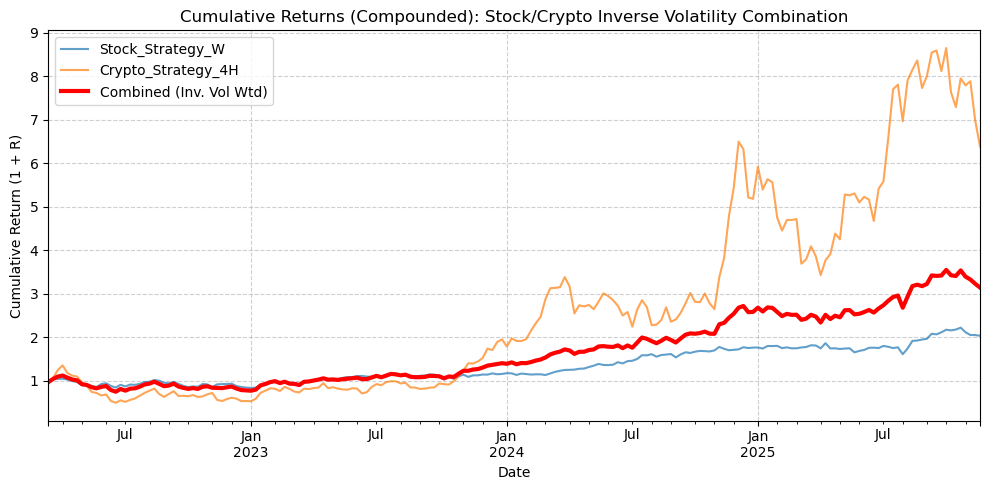

In [14]:
# --- HELPER FUNCTIONS (REQUIRED) ---

def max_drawdown(returns):
    """Calculates the maximum drawdown of a return series."""
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.expanding(min_periods=1).max()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

def drawdown_durations(cumulative_returns):
    """Calculates the duration of drawdowns."""
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = cumulative_returns < peak
    
    if drawdown.any():
        # Ensure correct handling of boolean Series and indexing
        # Filter down to the periods actually in a drawdown
        in_drawdown = drawdown[drawdown].index
        
        # If there are drawdown periods, calculate durations
        if not in_drawdown.empty:
            # Group consecutive True values to find drawdown lengths
            group_keys = (drawdown != drawdown.shift()).cumsum()
            drawdown_periods = drawdown.groupby(group_keys).sum()
            max_dd_time = drawdown_periods.max()
        else:
            max_dd_time = 0
    else:
        max_dd_time = 0
        
    return drawdown, max_dd_time

# ----------------------------------------------------
# 📌 GLOBAL CONFIGURATION & ASSUMPTIONS
# ----------------------------------------------------
# Global variables for the two strategy blocks
periods_per_day = 6  # 4-hour periods
n_trading_days = 252 
annual_periods_H1 = n_trading_days * periods_per_day # 1512 (4H frequency)
periods_per_year_W = 52 # Weekly frequency

# Stock Strategy Parameters
LAG_PERIODS = 4
tcost_bps = 20
BEST_HORIZON = 26 
N_SELECTED = 5 # Use N=5 as requested for the final stock strategy

# Assuming 'ret' (weekly stock returns) and 'returns_crypto' (4H crypto returns) are defined.

# ----------------------------------------------------
## 🟣 STRATEGY 1: HIGH-FREQUENCY CRYPTO ENSEMBLE (4H Returns)
# ----------------------------------------------------

# --- A. Time Series Split (4H) ---
split_date = '2024-01-01' 
train_ret_h1 = returns_crypto.loc[returns_crypto.index < split_date]
test_ret_h1 = returns_crypto.loc[returns_crypto.index >= split_date]
horizons_to_test = [4, 5, 6, 30, 1512] 

# --- B. TRAIN PHASE (Optimization) ---
strats_train_h1 = {}
for hor in horizons_to_test:
    avg_ret_signal = train_ret_h1.rolling(hor, min_periods=1).mean().rank(pct=True)
    long_only_signal = (1 - avg_ret_signal) 
    weights = long_only_signal.rank(axis=1)
    weights = weights.divide(weights.sum(axis=1), axis=0)
    strat = (weights.shift() * train_ret_h1).sum(axis=1)
    strats_train_h1[hor] = strat

strats_train_h1 = pd.DataFrame(strats_train_h1)
to_train_h1 = (strats_train_h1.fillna(0) - strats_train_h1.shift().fillna(0)).abs()
T_cost_tot_train_h1 = to_train_h1 * tcost_bps * 1e-4
net_ret_train_h1 = strats_train_h1.sub(T_cost_tot_train_h1, fill_value=0)

sharpe_ratio_train_h1 = net_ret_train_h1.mean() * np.sqrt(annual_periods_H1) / net_ret_train_h1.std()
total_SR_train_h1 = sharpe_ratio_train_h1.sum()
weights_optimized_h1 = sharpe_ratio_train_h1 / total_SR_train_h1

# --- C. TEST PHASE (Deployment) ---
strats_test_h1 = {}
for hor in horizons_to_test:
    avg_ret_signal = test_ret_h1.rolling(hor, min_periods=1).mean().rank(pct=True)
    long_only_signal = (1 - avg_ret_signal)
    weights = long_only_signal.rank(axis=1)
    weights = weights.divide(weights.sum(axis=1), axis=0)
    strat = (weights.shift() * test_ret_h1).sum(axis=1)
    strats_test_h1[hor] = strat

strats_test_h1 = pd.DataFrame(strats_test_h1).fillna(0)
to_test_h1 = (strats_test_h1.fillna(0) - strats_test_h1.shift().fillna(0)).abs()
T_cost_tot_test_h1 = to_test_h1 * tcost_bps * 1e-4
net_ret_test_h1 = strats_test_h1.sub(T_cost_tot_test_h1, fill_value=0)
ensemble_ret_test_h1 = net_ret_test_h1.dot(weights_optimized_h1)

# --- D. Final 4H Returns Series ---
ensemble_ret_full_h1 = pd.concat([net_ret_train_h1.dot(weights_optimized_h1), ensemble_ret_test_h1])
ensemble_ret_full_h1.rename('Crypto_Strategy_4H', inplace=True)
print("\n--- Strategy 1 (Crypto) Calculated. ---")

# ----------------------------------------------------
## 🟢 STRATEGY 2: WEEKLY STOCK TOP-N REVERSAL (Weekly Returns)
# ----------------------------------------------------

# --- A. Strategy Calculation (Full Period, N=5) ---
print(f"Starting Stock Reversal Strategy (H={BEST_HORIZON}, N={N_SELECTED})...")
avg_ret_raw = ret.rolling(BEST_HORIZON, min_periods=BEST_HORIZON).mean().rank(pct=True)
avg_ret_raw = avg_ret_raw.subtract(avg_ret_raw.mean(axis=1), axis=0)
raw_reversal_signal = -avg_ret_raw 

final_weights_N = pd.DataFrame(0.0, index=ret.index, columns=ret.columns)

# Loop to apply Top-N and Long-Only constraint period-by-period
for t in ret.index:
    signal_t = raw_reversal_signal.loc[t].clip(lower=0).fillna(0)
    
    if signal_t.sum() > 0:
        # Top-N Filter
        top_n_signals = signal_t.nlargest(N_SELECTED)
        selected_tickers = top_n_signals.index
        filtered_weights_t = signal_t.loc[selected_tickers]
        
        # Normalize: Sum(w_i) = 1
        if filtered_weights_t.sum() > 0:
            normalized_weights_t = filtered_weights_t / filtered_weights_t.sum()
            final_weights_N.loc[t, normalized_weights_t.index] = normalized_weights_t

# --- B. Calculate Net Returns ---
lagged_weights = final_weights_N.shift(LAG_PERIODS).fillna(0)
strat_gross = (lagged_weights * ret).sum(axis=1)

turnover_change = lagged_weights - lagged_weights.shift()
turnover_series = turnover_change.abs().sum(axis=1).fillna(0) 

cost_series = turnover_series * tcost_bps * 1e-4
net_ret_w = strat_gross.sub(cost_series, axis=0)
net_ret_w.rename('Stock_Strategy_W', inplace=True)
print("--- Strategy 2 (Stock) Calculated. ---")


# ----------------------------------------------------
## 🚀 FINAL COMBINATION: STATIC INVERSE VOLATILITY WEIGHTING
# ----------------------------------------------------

print("\n### Starting Final Portfolio Combination (Static Inverse Volatility) ###")

# 1. Align and Resample Strategy 1 (4H) to Weekly
# (1 + R_weekly) = Product(1 + R_4h)
REBALANCE_FREQ = 'W' # Standard Weekly Resampling
Strategy_A_Weekly = net_ret_w # Already Weekly
Strategy_B_Weekly = (1 + ensemble_ret_full_h1).resample(REBALANCE_FREQ).prod() - 1

# 2. Align the two weekly return streams (inner join to keep only common dates)
final_strategies_w = pd.concat([Strategy_A_Weekly, Strategy_B_Weekly], axis=1).dropna()
Strategy_A_Returns = final_strategies_w['Stock_Strategy_W']
Strategy_B_Returns = final_strategies_w['Crypto_Strategy_4H']

# 3. Calculate Inverse Volatility Weights (Static over the full period)
vol_A = Strategy_A_Returns.std()
vol_B = Strategy_B_Returns.std()

# Safety check for zero volatility
if vol_A == 0 or vol_B == 0:
    print("\n[WARNING] One strategy has zero volatility. Using 50/50 weights.")
    W_A = 0.5
    W_B = 0.5
else:
    inv_vol_A = 1 / vol_A
    inv_vol_B = 1 / vol_B
    normalization_factor = inv_vol_A + inv_vol_B
    W_A = inv_vol_A / normalization_factor
    W_B = inv_vol_B / normalization_factor

print("\n--- Final Static Inverse Volatility Weights ---")
print(f"Volatility Strategy A (Stock): {vol_A:.5f}")
print(f"Volatility Strategy B (Crypto): {vol_B:.5f}")
print(f"Weight Strategy A (W_A): {W_A:.3f}")
print(f"Weight Strategy B (W_B): {W_B:.3f}")

# 4. Create the Combined Returns Series
final_combined_returns = (
    Strategy_A_Returns * W_A +
    Strategy_B_Returns * W_B
).rename('Final_Combined_Returns_InvVol')

# 5. Analyze and Plot Final Performance
final_sr = final_combined_returns.mean() * np.sqrt(periods_per_year_W) / final_combined_returns.std()
final_ann_ret = (1 + final_combined_returns.mean())**periods_per_year_W - 1

print("\n--- Final Combined Portfolio Performance ---")
print(f"Final Annualized Sharpe Ratio: {final_sr:.3f}")
print(f"Final Approx. Annual Return: {final_ann_ret:.4f}")

# Plotting Comparison using Cumulative Product (Compounding)
cumulative_A = (1 + Strategy_A_Returns).cumprod()
cumulative_B = (1 + Strategy_B_Returns).cumprod()
cumulative_Final = (1 + final_combined_returns).cumprod()

plt.figure(figsize=(10, 5))
cumulative_A.plot(label=Strategy_A_Returns.name, linewidth=1.5, alpha=0.7)
cumulative_B.plot(label=Strategy_B_Returns.name, linewidth=1.5, alpha=0.7)
cumulative_Final.plot(label='Combined (Inv. Vol Wtd)', color='red', linewidth=3)

plt.title("Cumulative Returns (Compounded): Stock/Crypto Inverse Volatility Combination")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (1 + R)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


--- Strategy 1 (Crypto) Calculated. ---
Starting Stock Reversal Strategy (H=26, N=5)...
--- Strategy 2 (Stock) Calculated. ---

### Starting Final Portfolio Combination (Static Inverse Volatility) ###

--- Strategy Component Performance (Weekly Basis) ---
Stock Strategy (W_A) Sharpe Ratio: 0.958
Crypto Strategy (W_B) Sharpe Ratio: 1.079

--- Final Static Inverse Volatility Weights ---
Volatility Strategy A (Stock): 0.03134
Volatility Strategy B (Crypto): 0.09260
Weight Strategy A (W_A): 0.747
Weight Strategy B (W_B): 0.253

--- Final Combined Portfolio Performance ---
Final Annualized Sharpe Ratio: 1.276
Final Approx. Annual Return: 0.4090


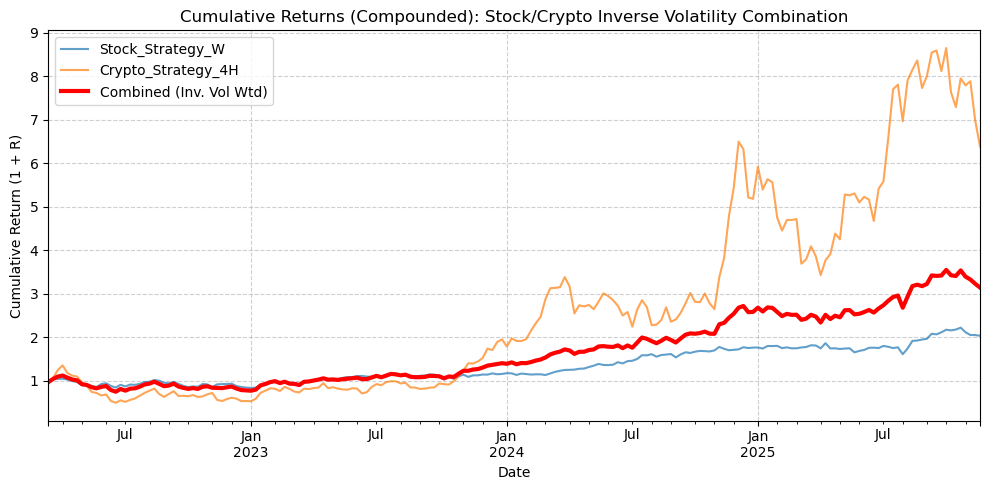

In [15]:
# ----------------------------------------------------
# 📌 GLOBAL CONFIGURATION & ASSUMPTIONS
# ----------------------------------------------------
# Global variables for the two strategy blocks
periods_per_day = 6  # 4-hour periods
n_trading_days = 252 
annual_periods_H1 = n_trading_days * periods_per_day # 1512 (4H frequency)
periods_per_year_W = 52 # Weekly frequency

# Stock Strategy Parameters
LAG_PERIODS = 4
tcost_bps = 20
BEST_HORIZON = 26 
N_SELECTED = 5 # Use N=5 as requested for the final stock strategy

# Assuming 'ret' (weekly stock returns) and 'returns_crypto' (4H crypto returns) are defined.

# ----------------------------------------------------
## 🟣 STRATEGY 1: HIGH-FREQUENCY CRYPTO ENSEMBLE (4H Returns)
# ----------------------------------------------------

# --- A. Time Series Split (4H) ---
split_date = '2024-01-01' 
train_ret_h1 = returns_crypto.loc[returns_crypto.index < split_date]
test_ret_h1 = returns_crypto.loc[returns_crypto.index >= split_date]
horizons_to_test = [4, 5, 6, 30, 1512] 

# --- B. TRAIN PHASE (Optimization) ---
strats_train_h1 = {}
for hor in horizons_to_test:
    avg_ret_signal = train_ret_h1.rolling(hor, min_periods=1).mean().rank(pct=True)
    long_only_signal = (1 - avg_ret_signal) 
    weights = long_only_signal.rank(axis=1)
    weights = weights.divide(weights.sum(axis=1), axis=0)
    strat = (weights.shift() * train_ret_h1).sum(axis=1)
    strats_train_h1[hor] = strat

strats_train_h1 = pd.DataFrame(strats_train_h1)
to_train_h1 = (strats_train_h1.fillna(0) - strats_train_h1.shift().fillna(0)).abs()
T_cost_tot_train_h1 = to_train_h1 * tcost_bps * 1e-4
net_ret_train_h1 = strats_train_h1.sub(T_cost_tot_train_h1, fill_value=0)

sharpe_ratio_train_h1 = net_ret_train_h1.mean() * np.sqrt(annual_periods_H1) / net_ret_train_h1.std()
total_SR_train_h1 = sharpe_ratio_train_h1.sum()
weights_optimized_h1 = sharpe_ratio_train_h1 / total_SR_train_h1

# --- C. TEST PHASE (Deployment) ---
strats_test_h1 = {}
for hor in horizons_to_test:
    avg_ret_signal = test_ret_h1.rolling(hor, min_periods=1).mean().rank(pct=True)
    long_only_signal = (1 - avg_ret_signal)
    weights = long_only_signal.rank(axis=1)
    weights = weights.divide(weights.sum(axis=1), axis=0)
    strat = (weights.shift() * test_ret_h1).sum(axis=1)
    strats_test_h1[hor] = strat

strats_test_h1 = pd.DataFrame(strats_test_h1).fillna(0)
to_test_h1 = (strats_test_h1.fillna(0) - strats_test_h1.shift().fillna(0)).abs()
T_cost_tot_test_h1 = to_test_h1 * tcost_bps * 1e-4
net_ret_test_h1 = strats_test_h1.sub(T_cost_tot_test_h1, fill_value=0)
ensemble_ret_test_h1 = net_ret_test_h1.dot(weights_optimized_h1)

# --- D. Final 4H Returns Series ---
ensemble_ret_full_h1 = pd.concat([net_ret_train_h1.dot(weights_optimized_h1), ensemble_ret_test_h1])
ensemble_ret_full_h1.rename('Crypto_Strategy_4H', inplace=True)
print("\n--- Strategy 1 (Crypto) Calculated. ---")

# ----------------------------------------------------
## 🟢 STRATEGY 2: WEEKLY STOCK TOP-N REVERSAL (Weekly Returns)
# ----------------------------------------------------

# --- A. Strategy Calculation (Full Period, N=5) ---
print(f"Starting Stock Reversal Strategy (H={BEST_HORIZON}, N={N_SELECTED})...")
avg_ret_raw = ret.rolling(BEST_HORIZON, min_periods=BEST_HORIZON).mean().rank(pct=True)
avg_ret_raw = avg_ret_raw.subtract(avg_ret_raw.mean(axis=1), axis=0)
raw_reversal_signal = -avg_ret_raw 

final_weights_N = pd.DataFrame(0.0, index=ret.index, columns=ret.columns)

# Loop to apply Top-N and Long-Only constraint period-by-period
for t in ret.index:
    signal_t = raw_reversal_signal.loc[t].clip(lower=0).fillna(0)
    
    if signal_t.sum() > 0:
        # Top-N Filter
        top_n_signals = signal_t.nlargest(N_SELECTED)
        selected_tickers = top_n_signals.index
        filtered_weights_t = signal_t.loc[selected_tickers]
        
        # Normalize: Sum(w_i) = 1
        if filtered_weights_t.sum() > 0:
            normalized_weights_t = filtered_weights_t / filtered_weights_t.sum()
            final_weights_N.loc[t, normalized_weights_t.index] = normalized_weights_t

# --- B. Calculate Net Returns ---
lagged_weights = final_weights_N.shift(LAG_PERIODS).fillna(0)
strat_gross = (lagged_weights * ret).sum(axis=1)

turnover_change = lagged_weights - lagged_weights.shift()
turnover_series = turnover_change.abs().sum(axis=1).fillna(0) 

cost_series = turnover_series * tcost_bps * 1e-4
net_ret_w = strat_gross.sub(cost_series, axis=0)
net_ret_w.rename('Stock_Strategy_W', inplace=True)
print("--- Strategy 2 (Stock) Calculated. ---")


# ----------------------------------------------------
## 🚀 FINAL COMBINATION: STATIC INVERSE VOLATILITY WEIGHTING
# ----------------------------------------------------

print("\n### Starting Final Portfolio Combination (Static Inverse Volatility) ###")

# 1. Align and Resample Strategy 1 (4H) to Weekly
REBALANCE_FREQ = 'W' # Standard Weekly Resampling
Strategy_A_Weekly = net_ret_w # Already Weekly
Strategy_B_Weekly = (1 + ensemble_ret_full_h1).resample(REBALANCE_FREQ).prod() - 1

# 2. Align the two weekly return streams (inner join to keep only common dates)
final_strategies_w = pd.concat([Strategy_A_Weekly, Strategy_B_Weekly], axis=1).dropna()
Strategy_A_Returns = final_strategies_w['Stock_Strategy_W']
Strategy_B_Returns = final_strategies_w['Crypto_Strategy_4H']

# 3. Calculate Component Sharpe Ratios (Weekly Annualized)
sharpe_A = Strategy_A_Returns.mean() * np.sqrt(periods_per_year_W) / Strategy_A_Returns.std()
sharpe_B = Strategy_B_Returns.mean() * np.sqrt(periods_per_year_W) / Strategy_B_Returns.std()

# 4. Calculate Inverse Volatility Weights (Static over the full period)
vol_A = Strategy_A_Returns.std()
vol_B = Strategy_B_Returns.std()

# Safety check for zero volatility
if vol_A == 0 or vol_B == 0:
    print("\n[WARNING] One strategy has zero volatility. Using 50/50 weights.")
    W_A = 0.5
    W_B = 0.5
else:
    inv_vol_A = 1 / vol_A
    inv_vol_B = 1 / vol_B
    normalization_factor = inv_vol_A + inv_vol_B
    W_A = inv_vol_A / normalization_factor
    W_B = inv_vol_B / normalization_factor

print("\n--- Strategy Component Performance (Weekly Basis) ---")
print(f"Stock Strategy (W_A) Sharpe Ratio: {sharpe_A:.3f}")
print(f"Crypto Strategy (W_B) Sharpe Ratio: {sharpe_B:.3f}")

print("\n--- Final Static Inverse Volatility Weights ---")
print(f"Volatility Strategy A (Stock): {vol_A:.5f}")
print(f"Volatility Strategy B (Crypto): {vol_B:.5f}")
print(f"Weight Strategy A (W_A): {W_A:.3f}")
print(f"Weight Strategy B (W_B): {W_B:.3f}")

# 5. Create the Combined Returns Series
final_combined_returns = (
    Strategy_A_Returns * W_A +
    Strategy_B_Returns * W_B
).rename('Final_Combined_Returns_InvVol')

# 6. Analyze and Plot Final Performance
final_sr = final_combined_returns.mean() * np.sqrt(periods_per_year_W) / final_combined_returns.std()
final_ann_ret = (1 + final_combined_returns.mean())**periods_per_year_W - 1

print("\n--- Final Combined Portfolio Performance ---")
print(f"Final Annualized Sharpe Ratio: {final_sr:.3f}")
print(f"Final Approx. Annual Return: {final_ann_ret:.4f}")

# Plotting Comparison using Cumulative Product (Compounding)
cumulative_A = (1 + Strategy_A_Returns).cumprod()
cumulative_B = (1 + Strategy_B_Returns).cumprod()
cumulative_Final = (1 + final_combined_returns).cumprod()

plt.figure(figsize=(10, 5))
cumulative_A.plot(label=Strategy_A_Returns.name, linewidth=1.5, alpha=0.7)
cumulative_B.plot(label=Strategy_B_Returns.name, linewidth=1.5, alpha=0.7)
cumulative_Final.plot(label='Combined (Inv. Vol Wtd)', color='red', linewidth=3)

plt.title("Cumulative Returns (Compounded): Stock/Crypto Inverse Volatility Combination")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (1 + R)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


--- Strategy 1 (Crypto) Calculated. ---

🔍 **CRYPTO STRATEGY: OPTIMIZED HORIZON WEIGHTS (FIXED)** 🔍
4       0.2466
5       0.2369
6       0.2368
30      0.1471
1512    0.1326
dtype: object

Starting Stock Reversal Strategy (H=26, N=5)...
--- Strategy 2 (Stock) Calculated. ---

🔍 **STOCK STRATEGY: WEEKLY SELECTION & WEIGHTS (LAST 3 PERIODS)** 🔍
Symbols       AMZN     JPM     UNH     WMT     XOM
Date                                              
2025-11-09  0.0000  0.0000  0.5565  0.3138  0.1297
2025-11-16  0.1101  0.2908  0.0000  0.4774  0.1217
2025-11-23  0.2399  0.3176  0.0846  0.2621  0.0957

### Starting Final Portfolio Combination (Static Inverse Volatility) ###

--- Strategy Component Performance (Weekly Basis) ---
Stock Strategy (W_A) Sharpe Ratio: 0.958
Crypto Strategy (W_B) Sharpe Ratio: 1.079

--- Final Static Inverse Volatility Weights ---
Volatility Strategy A (Stock): 0.03134
Volatility Strategy B (Crypto): 0.09260
Weight Strategy A (W_A): 0.747
Weight Strategy B (W_B): 0.

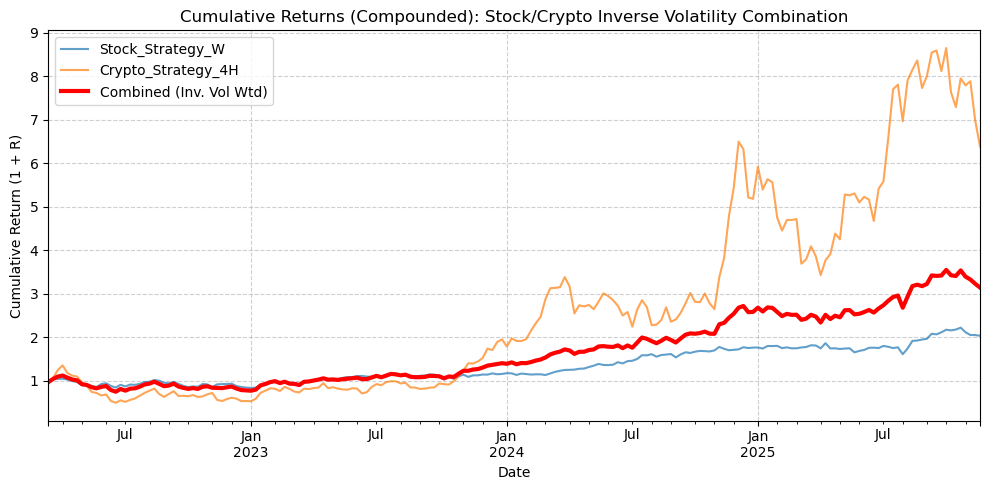

In [21]:
#Combined Strategy with weight print
# ----------------------------------------------------
# 📌 GLOBAL CONFIGURATION & ASSUMPTIONS
# ----------------------------------------------------
periods_per_day = 6  # 4-hour periods
n_trading_days = 252 
annual_periods_H1 = n_trading_days * periods_per_day # 1512 (4H frequency)
periods_per_year_W = 52 # Weekly frequency

# Stock Strategy Parameters
LAG_PERIODS = 4
tcost_bps = 20
BEST_HORIZON = 26 
N_SELECTED = 5 # Use N=5 as requested for the final stock strategy

# Assuming 'ret' (weekly stock returns) and 'returns_crypto' (4H crypto returns) are defined.

# ----------------------------------------------------
## 🟣 STRATEGY 1: HIGH-FREQUENCY CRYPTO ENSEMBLE (4H Returns)
# ----------------------------------------------------

# --- A. Time Series Split (4H) ---
split_date = '2024-01-01' 
train_ret_h1 = returns_crypto.loc[returns_crypto.index < split_date]
test_ret_h1 = returns_crypto.loc[returns_crypto.index >= split_date]
horizons_to_test = [4, 5, 6, 30, 1512] 

# --- B. TRAIN PHASE (Optimization) ---
strats_train_h1 = {}
for hor in horizons_to_test:
    avg_ret_signal = train_ret_h1.rolling(hor, min_periods=1).mean().rank(pct=True)
    long_only_signal = (1 - avg_ret_signal) 
    weights = long_only_signal.rank(axis=1)
    weights = weights.divide(weights.sum(axis=1), axis=0)
    strat = (weights.shift() * train_ret_h1).sum(axis=1)
    strats_train_h1[hor] = strat

strats_train_h1 = pd.DataFrame(strats_train_h1)
to_train_h1 = (strats_train_h1.fillna(0) - strats_train_h1.shift().fillna(0)).abs()
T_cost_tot_train_h1 = to_train_h1 * tcost_bps * 1e-4
net_ret_train_h1 = strats_train_h1.sub(T_cost_tot_train_h1, fill_value=0)

sharpe_ratio_train_h1 = net_ret_train_h1.mean() * np.sqrt(annual_periods_H1) / net_ret_train_h1.std()
total_SR_train_h1 = sharpe_ratio_train_h1.sum()
weights_optimized_h1 = sharpe_ratio_train_h1 / total_SR_train_h1

# --- C. TEST PHASE (Deployment) ---
strats_test_h1 = {}
for hor in horizons_to_test:
    avg_ret_signal = test_ret_h1.rolling(hor, min_periods=1).mean().rank(pct=True)
    long_only_signal = (1 - avg_ret_signal)
    weights = long_only_signal.rank(axis=1)
    weights = weights.divide(weights.sum(axis=1), axis=0)
    strat = (weights.shift() * test_ret_h1).sum(axis=1)
    strats_test_h1[hor] = strat

strats_test_h1 = pd.DataFrame(strats_test_h1).fillna(0)
to_test_h1 = (strats_test_h1.fillna(0) - strats_test_h1.shift().fillna(0)).abs()
T_cost_tot_test_h1 = to_test_h1 * tcost_bps * 1e-4
net_ret_test_h1 = strats_test_h1.sub(T_cost_tot_test_h1, fill_value=0)
ensemble_ret_test_h1 = net_ret_test_h1.dot(weights_optimized_h1)

# --- D. Final 4H Returns Series ---
ensemble_ret_full_h1 = pd.concat([net_ret_train_h1.dot(weights_optimized_h1), ensemble_ret_test_h1])
ensemble_ret_full_h1.rename('Crypto_Strategy_4H', inplace=True)
print("\n--- Strategy 1 (Crypto) Calculated. ---")

# --- EMBEDDED PRINT 1: Crypto Ensemble Weights ---
print("\n🔍 **CRYPTO STRATEGY: OPTIMIZED HORIZON WEIGHTS (FIXED)** 🔍")
print(weights_optimized_h1.map('{:.4f}'.format))

# ----------------------------------------------------
## 🟢 STRATEGY 2: WEEKLY STOCK TOP-N REVERSAL (Weekly Returns)
# ----------------------------------------------------

# --- A. Strategy Calculation (Full Period, N=5) ---
print(f"\nStarting Stock Reversal Strategy (H={BEST_HORIZON}, N={N_SELECTED})...")
avg_ret_raw = ret.rolling(BEST_HORIZON, min_periods=BEST_HORIZON).mean().rank(pct=True)
avg_ret_raw = avg_ret_raw.subtract(avg_ret_raw.mean(axis=1), axis=0)
raw_reversal_signal = -avg_ret_raw 

final_weights_N = pd.DataFrame(0.0, index=ret.index, columns=ret.columns)

# Loop to apply Top-N and Long-Only constraint period-by-period
for t in ret.index:
    signal_t = raw_reversal_signal.loc[t].clip(lower=0).fillna(0)
    
    if signal_t.sum() > 0:
        # Top-N Filter
        top_n_signals = signal_t.nlargest(N_SELECTED)
        selected_tickers = top_n_signals.index
        filtered_weights_t = signal_t.loc[selected_tickers]
        
        # Normalize: Sum(w_i) = 1
        if filtered_weights_t.sum() > 0:
            normalized_weights_t = filtered_weights_t / filtered_weights_t.sum()
            final_weights_N.loc[t, normalized_weights_t.index] = normalized_weights_t

# --- B. Calculate Net Returns ---
lagged_weights = final_weights_N.shift(LAG_PERIODS).fillna(0)
strat_gross = (lagged_weights * ret).sum(axis=1)

turnover_change = lagged_weights - lagged_weights.shift()
turnover_series = turnover_change.abs().sum(axis=1).fillna(0) 

cost_series = turnover_series * tcost_bps * 1e-4
net_ret_w = strat_gross.sub(cost_series, axis=0)
net_ret_w.rename('Stock_Strategy_W', inplace=True)
print("--- Strategy 2 (Stock) Calculated. ---")

# --- EMBEDDED PRINT 2: Stock Selection for Last 3 Weeks ---
print("\n🔍 **STOCK STRATEGY: WEEKLY SELECTION & WEIGHTS (LAST 3 PERIODS)** 🔍")
weights_last_3 = final_weights_N.tail(3).replace(0, np.nan).dropna(axis=1, how='all').fillna(0)
print(weights_last_3.round(4))


# ----------------------------------------------------
## 🚀 FINAL COMBINATION: STATIC INVERSE VOLATILITY WEIGHTING
# ----------------------------------------------------

print("\n### Starting Final Portfolio Combination (Static Inverse Volatility) ###")

# 1. Align and Resample Strategy 1 (4H) to Weekly
REBALANCE_FREQ = 'W' # Standard Weekly Resampling
Strategy_A_Weekly = net_ret_w # Already Weekly
Strategy_B_Weekly = (1 + ensemble_ret_full_h1).resample(REBALANCE_FREQ).prod() - 1

# 2. Align the two weekly return streams (inner join to keep only common dates)
final_strategies_w = pd.concat([Strategy_A_Weekly, Strategy_B_Weekly], axis=1).dropna()
Strategy_A_Returns = final_strategies_w['Stock_Strategy_W']
Strategy_B_Returns = final_strategies_w['Crypto_Strategy_4H']

# 3. Calculate Component Sharpe Ratios (Weekly Annualized)
sharpe_A = Strategy_A_Returns.mean() * np.sqrt(periods_per_year_W) / Strategy_A_Returns.std()
sharpe_B = Strategy_B_Returns.mean() * np.sqrt(periods_per_year_W) / Strategy_B_Returns.std()

# 4. Calculate Inverse Volatility Weights (Static over the full period)
vol_A = Strategy_A_Returns.std()
vol_B = Strategy_B_Returns.std()

# Safety check for zero volatility
if vol_A == 0 or vol_B == 0:
    print("\n[WARNING] One strategy has zero volatility. Using 50/50 weights.")
    W_A = 0.5
    W_B = 0.5
else:
    inv_vol_A = 1 / vol_A
    inv_vol_B = 1 / vol_B
    normalization_factor = inv_vol_A + inv_vol_B
    W_A = inv_vol_A / normalization_factor
    W_B = inv_vol_B / normalization_factor

print("\n--- Strategy Component Performance (Weekly Basis) ---")
print(f"Stock Strategy (W_A) Sharpe Ratio: {sharpe_A:.3f}")
print(f"Crypto Strategy (W_B) Sharpe Ratio: {sharpe_B:.3f}")

print("\n--- Final Static Inverse Volatility Weights ---")
print(f"Volatility Strategy A (Stock): {vol_A:.5f}")
print(f"Volatility Strategy B (Crypto): {vol_B:.5f}")
print(f"Weight Strategy A (W_A): {W_A:.3f}")
print(f"Weight Strategy B (W_B): {W_B:.3f}")

# 5. Create the Combined Returns Series
final_combined_returns = (
    Strategy_A_Returns * W_A +
    Strategy_B_Returns * W_B
).rename('Final_Combined_Returns_InvVol')

# 6. Analyze and Plot Final Performance
final_sr = final_combined_returns.mean() * np.sqrt(periods_per_year_W) / final_combined_returns.std()
final_ann_ret = (1 + final_combined_returns.mean())**periods_per_year_W - 1

print("\n--- Final Combined Portfolio Performance ---")
print(f"Final Annualized Sharpe Ratio: {final_sr:.3f}")
print(f"Final Approx. Annual Return: {final_ann_ret:.4f}")

# ----------------------------------------------------
# 🔍 EMBEDDED PRINT 3: Final Crypto Asset Weights for one period
# ----------------------------------------------------

# 1. Calculate the final, weighted asset weights for the TEST period.
#    This combines the weights from all time horizons (hor) into a single weight per asset.
final_asset_weights_test = pd.DataFrame()
for hor in strats_test_h1.columns:
    # 1. Calculate the normalized weights for this specific horizon (same logic as before)
    avg_ret_signal = test_ret_h1.rolling(int(hor), min_periods=1).mean().rank(pct=True)
    long_only_signal = (1 - avg_ret_signal)
    weights_raw = long_only_signal.rank(axis=1)
    weights_normalized = weights_raw.divide(weights_raw.sum(axis=1), axis=0).fillna(0)
    
    # 2. Multiply by the optimized ensemble weight for this horizon
    weighted_asset_weights = weights_normalized.multiply(weights_optimized_h1[hor], axis=0)
    
    # Sum up the contributions from all horizons
    if final_asset_weights_test.empty:
        final_asset_weights_test = weighted_asset_weights
    else:
        final_asset_weights_test = final_asset_weights_test.add(weighted_asset_weights, fill_value=0)

# 3. Print the final asset weights for the last available 4-hour period.
last_period = final_asset_weights_test.index[-1]
weights_to_print = final_asset_weights_test.loc[last_period]
weights_to_print = weights_to_print[weights_to_print > 0.0001] # Filter out near-zero weights

print(f"\n\n🔍 **FINAL CRYPTO ASSET WEIGHTS FOR PERIOD: {last_period}** 🔍")
print("These are the specific crypto coins and the proportion of capital to invest in each:")
print("---------------------------------------------------------------------------------")
print(weights_to_print.sort_values(ascending=False).map('{:.4f}'.format))

# Plotting Comparison using Cumulative Product (Compounding)
cumulative_A = (1 + Strategy_A_Returns).cumprod()
cumulative_B = (1 + Strategy_B_Returns).cumprod()
cumulative_Final = (1 + final_combined_returns).cumprod()


plt.figure(figsize=(10, 5))
cumulative_A.plot(label=Strategy_A_Returns.name, linewidth=1.5, alpha=0.7)
cumulative_B.plot(label=Strategy_B_Returns.name, linewidth=1.5, alpha=0.7)
cumulative_Final.plot(label='Combined (Inv. Vol Wtd)', color='red', linewidth=3)

plt.title("Cumulative Returns (Compounded): Stock/Crypto Inverse Volatility Combination")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (1 + R)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Assuming test_ret_h1, weights_optimized_h1, and net_ret_test_h1 are available from previous execution.
# This code block focuses on printing the individual crypto asset weights.

# ----------------------------------------------------
# 🔍 EMBEDDED PRINT 3: Final Crypto Asset Weights for one period
# ----------------------------------------------------

# 1. Calculate the final, weighted asset weights for the TEST period.
#    This combines the weights from all time horizons (hor) into a single weight per asset.
final_asset_weights_test = pd.DataFrame()
for hor in strats_test_h1.columns:
    # 1. Calculate the normalized weights for this specific horizon (same logic as before)
    avg_ret_signal = test_ret_h1.rolling(int(hor), min_periods=1).mean().rank(pct=True)
    long_only_signal = (1 - avg_ret_signal)
    weights_raw = long_only_signal.rank(axis=1)
    weights_normalized = weights_raw.divide(weights_raw.sum(axis=1), axis=0).fillna(0)
    
    # 2. Multiply by the optimized ensemble weight for this horizon
    weighted_asset_weights = weights_normalized.multiply(weights_optimized_h1[hor], axis=0)
    
    # Sum up the contributions from all horizons
    if final_asset_weights_test.empty:
        final_asset_weights_test = weighted_asset_weights
    else:
        final_asset_weights_test = final_asset_weights_test.add(weighted_asset_weights, fill_value=0)

# 3. Print the final asset weights for the last available 4-hour period.
last_period = final_asset_weights_test.index[-1]
weights_to_print = final_asset_weights_test.loc[last_period]
weights_to_print = weights_to_print[weights_to_print > 0.0001] # Filter out near-zero weights

print(f"\n\n🔍 **FINAL CRYPTO ASSET WEIGHTS FOR PERIOD: {last_period}** 🔍")
print("These are the specific crypto coins and the proportion of capital to invest in each:")
print("---------------------------------------------------------------------------------")
print(weights_to_print.sort_values(ascending=False).map('{:.4f}'.format))



🔍 **FINAL CRYPTO ASSET WEIGHTS FOR PERIOD: 2025-11-22 00:00:00** 🔍
These are the specific crypto coins and the proportion of capital to invest in each:
---------------------------------------------------------------------------------
DOTUSDT     0.0918
ATOMUSDT    0.0847
NEARUSDT    0.0827
SUIUSDT     0.0810
LINKUSDT    0.0764
LTCUSDT     0.0756
ADAUSDT     0.0684
HBARUSDT    0.0603
BTCUSDT     0.0594
AVAXUSDT    0.0576
BNBUSDT     0.0542
ETHUSDT     0.0494
XRPUSDT     0.0407
ETCUSDT     0.0352
AAVEUSDT    0.0321
XLMUSDT     0.0294
UNIUSDT     0.0152
ICPUSDT     0.0058
Name: 2025-11-22 00:00:00, dtype: object
